# Configuring demography
The {class}`~phasegen.distributions.Coalescent` expects a demography object to be passed to it, which can be configured in various ways. When constructing a demography object, you can directly specify the time points at which the population sizes or migration rates change.

In [1]:
devtools::install_github("Sendrowski/PhaseGen")

library(phasegen)

setwd("~/PycharmProjects/PhaseGen/")

Using GitHub PAT from the git credential store.

Skipping install of 'phasegen' from a github remote, the SHA1 (718d8dab) has not changed since last install.
  Use `force = TRUE` to force installation



In [2]:
library(phasegen)

pg <- load_phasegen()

Warning message in poetry_config(required_module):
“This project appears to use Poetry for Python dependency management.
However, the 'poetry' command line tool is not available.
reticulate will be unable to activate this project.
Please ensure that 'poetry' is available on the PATH.”


In [3]:
d <- pg$Demography(c(
    pg$PopSizeChange(pop = 'pop_0', time = 0, size = 1),
    pg$PopSizeChange(pop = 'pop_1', time = 0, size = 2.5),
    pg$PopSizeChange(pop = 'pop_0', time = 1, size = 0.8),
    pg$MigrationRateChange(source = 'pop_0', dest = 'pop_1', time = 0, rate = 1.7),
    pg$MigrationRateChange(source = 'pop_0', dest = 'pop_1', time = 0.7, rate = 2),
    pg$MigrationRateChange(source = 'pop_1', dest = 'pop_0', time = 0, rate = 3)
))

for (epoch in reticulate::iterate(d$epochs)) {
    print(epoch$to_string())
}

[1] "Epoch(start_time=0, end_time=0.7, pop_sizes=(pop_0=1, pop_1=2.5), migration_rates=(pop_0->pop_0=0, pop_0->pop_1=1.7, pop_1->pop_0=3, pop_1->pop_1=0)"
[1] "Epoch(start_time=0.7, end_time=1, pop_sizes=(pop_0=1, pop_1=2.5), migration_rates=(pop_0->pop_0=0, pop_0->pop_1=2, pop_1->pop_0=3, pop_1->pop_1=0)"
[1] "Epoch(start_time=1, end_time=inf, pop_sizes=(pop_0=0.8, pop_1=2.5), migration_rates=(pop_0->pop_0=0, pop_0->pop_1=2, pop_1->pop_0=3, pop_1->pop_1=0)"


Alternatively, you can configure the demography object after construction by adding demographic events using {meth}`~phasegen.demography.Demography.add_event`.

This is similar to the [Msprime demography API](https://tskit.dev/msprime/docs/stable/demography.html), and we can easily convert to an [``msprime.Demography``](https://tskit.dev/msprime/docs/stable/api.html#msprime.Demography) object. Note that the reverse, converting an msprime demography to a native {class}`~phasegen.demography.Demography` object, is not currently supported due to ``phasegen``'s inherent restriction to discrete rate changes.

In [5]:
d_msprime <- d$to_msprime()

## Discretizing continuous demographies
There are also utilities for discretizing continuous demographies. In the example below, we create a discretized demography by passing a continuous callback function to {class}`~phasegen.demography.DiscretizedRateChange`. You can freely combine this with other demographic events. Note that the total runtime of the coalescent simulation is linear in the number of epochs, i.e., it is roughly a multiple of the number of epochs.

In [6]:
d <- pg$Demography(c(
    pg$DiscretizedRateChange(
        trajectory=function(t) { 1.5 + 0.5 * t },
        pop = 'pop_0',
        start_time = 0,
        end_time = 5,
        step_size = 0.5
    )
))

for (epoch in reticulate::iterate(d$epochs)) {
    print(epoch$to_string())
}

[1] "Epoch(start_time=0, end_time=0.5, pop_sizes=(pop_0=1.625)"
[1] "Epoch(start_time=0.5, end_time=1, pop_sizes=(pop_0=1.875)"
[1] "Epoch(start_time=1, end_time=1.5, pop_sizes=(pop_0=2.125)"
[1] "Epoch(start_time=1.5, end_time=2, pop_sizes=(pop_0=2.375)"
[1] "Epoch(start_time=2, end_time=2.5, pop_sizes=(pop_0=2.625)"
[1] "Epoch(start_time=2.5, end_time=3, pop_sizes=(pop_0=2.875)"
[1] "Epoch(start_time=3, end_time=3.5, pop_sizes=(pop_0=3.125)"
[1] "Epoch(start_time=3.5, end_time=4, pop_sizes=(pop_0=3.375)"
[1] "Epoch(start_time=4, end_time=4.5, pop_sizes=(pop_0=3.625)"
[1] "Epoch(start_time=4.5, end_time=5, pop_sizes=(pop_0=3.625)"
[1] "Epoch(start_time=5, end_time=5.5, pop_sizes=(pop_0=3.625)"
[1] "Epoch(start_time=5.5, end_time=inf, pop_sizes=(pop_0=3.625)"


For exponential growth or decline, you can also make use of {class}`~phasegen.demography.ExponentialPopSizeChanges`.

In [7]:
d <- pg$Demography(c(
    pg$ExponentialPopSizeChanges(
        initial_size = list(pop_0 = 1.5),
        growth_rate = 0.5,
        start_time = 0,
        end_time = 8,
        step_size = 0.5
    )
))

for (epoch in reticulate::iterate(pg$take_n(d$epochs, 5))) {
    print(epoch$to_string())
}

[1] "Epoch(start_time=0, end_time=0.5, pop_sizes=(pop_0=1.334)"
[1] "Epoch(start_time=0.5, end_time=1, pop_sizes=(pop_0=1.039)"
[1] "Epoch(start_time=1, end_time=1.5, pop_sizes=(pop_0=0.8092)"
[1] "Epoch(start_time=1.5, end_time=2, pop_sizes=(pop_0=0.6302)"
[1] "Epoch(start_time=2, end_time=2.5, pop_sizes=(pop_0=0.4908)"


## Population splits
Population splits (forwards in time) correspond to population mergers (backwards in time). Since ``phasegen`` does not support deterministic lineage movements due to its inherent structure, we can model a population split by specifying a large unidirectional migration rate from the derived to the ancestral population. Below, we model a population split where ``pop_0`` splits from ``pop_1`` at time 2. This corresponds to a population merger of the two populations at time 2 backwards in time, and we thus need to initialize both populations at time 0 in the present.

In [8]:
d <- pg$Demography(
    pop_sizes = list(pop_0 = 1, pop_1 = 3),
    events = c(
        pg$PopulationSplit(
            derived = 'pop_0',
            ancestral = 'pop_1',
            time = 2
        )
    )
)

Plotting the migration rates, we see that there is a large migration rate from ``pop_0`` to ``pop_1`` at time 2. All migration rates to the derived population (``pop_0``) are furthermore set to 0 at the time of the split.

In [9]:
for (epoch in reticulate::iterate(d$epochs)) {
    print(epoch$to_string())
}

[1] "Epoch(start_time=0, end_time=2, pop_sizes=(pop_0=1, pop_1=3), migration_rates=(pop_0->pop_0=0, pop_0->pop_1=0, pop_1->pop_0=0, pop_1->pop_1=0)"
[1] "Epoch(start_time=2, end_time=inf, pop_sizes=(pop_0=1, pop_1=3), migration_rates=(pop_0->pop_0=0, pop_0->pop_1=0, pop_1->pop_0=100, pop_1->pop_1=0)"


Wrapping in a {class}`~phasegen.distributions.Coalescent` object, by specifying the initial numbers of lineages in each population, we can visualize the tree height distribution. We see that the probability of absorption is 0 after to the split (forwards in time). This is because our scenario represents a *clean* population split, where the derived population is completely isolated from the ancestral population after the split, which makes coalescence between the two populations impossible.

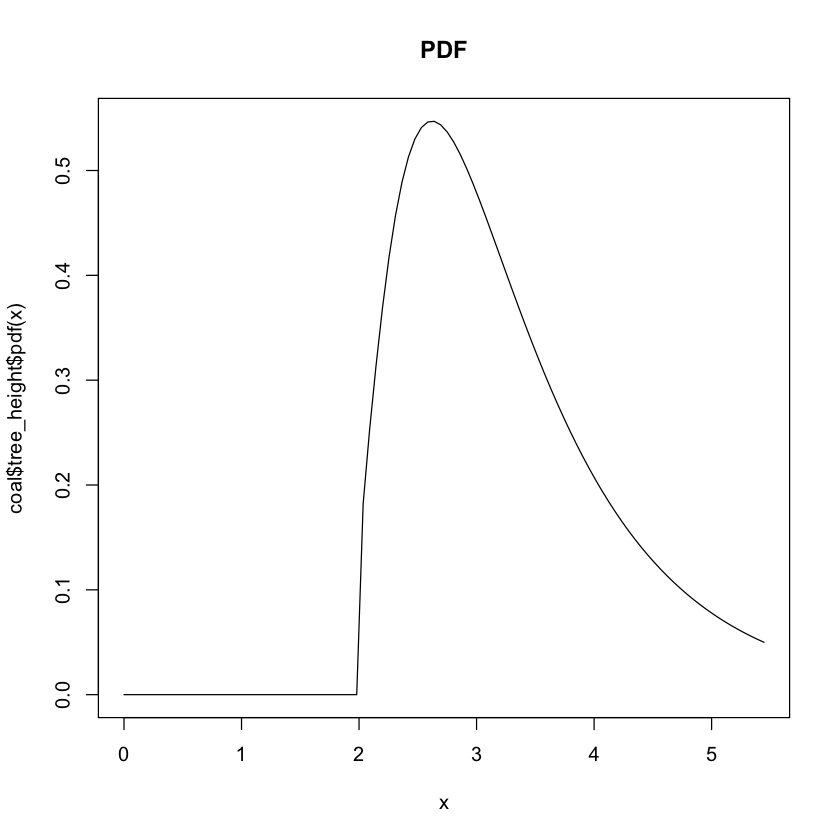

In [10]:
coal <- pg$Coalescent(
    n = list(pop_0 = 4, pop_1 = 4),
    demography = d
)

x <- seq(0, coal$tree_height$quantile(0.95), length.out = 100)

plot(x, coal$tree_height$pdf(x), type = "l", main = "PDF")

## Population mergers
Population mergers (forwards in time) correspond to population splits (backwards in time). Mergers of populations that were completely isolated prior to the merger are difficult to model in a coalescent framework. This is because, backwards in time, we would end up with isolated populations which would not be able to coalesce. We can thus only model mergers of populations, provided they are in contact again eventually. Below an example 

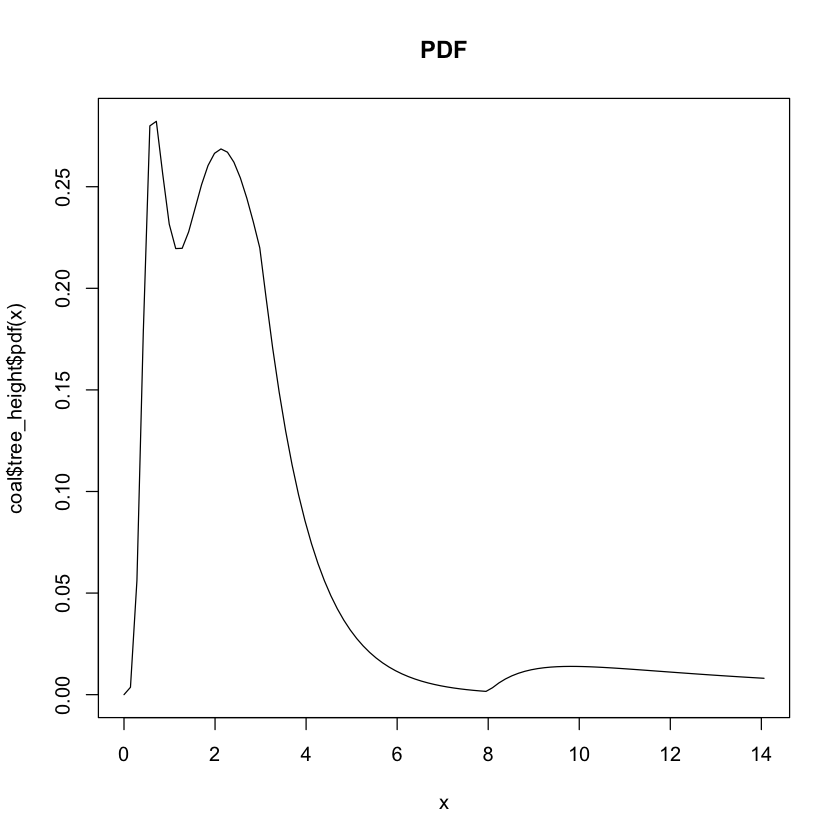

In [11]:
coal <- pg$Coalescent(
    n = list(pop_0 = 8, pop_1 = 0),
    demography = pg$Demography(
        pop_sizes = list(pop_0 = 1, pop_1 = 1),
        events=c(
            pg$MigrationRateChange(source = 'pop_1', dest = 'pop_0', time = 2, rate = 0),
            pg$MigrationRateChange(source = 'pop_1', dest = 'pop_0', time = 8, rate = 0.1),
            pg$MigrationRateChange(source = 'pop_0', dest = 'pop_1', time = 0.5, rate = 1),
            pg$MigrationRateChange(source = 'pop_0', dest = 'pop_1', time = 3, rate = 0),
            pg$MigrationRateChange(source = 'pop_0', dest = 'pop_1', time = 8, rate = 0.1)
        )
    )
)

x <- seq(0, coal$tree_height$quantile(0.95), length.out = 100)

plot(x, coal$tree_height$pdf(x), type = "l", main = "PDF")

```{note}
Migration rates between demes are assumed to be 0 if not specified otherwise.
```